In [2]:
df = pd.read_csv('income.csv')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [39]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [40]:
data = pd.read_csv("income.csv")

In [41]:
columns_to_encode = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
for col in columns_to_encode:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

data["income"] = (data["income"] == '>50K').astype(int)

In [42]:
X = data.drop("income", axis=1)
y = data["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [61]:
class IncomeClassifier(nn.Module):
    def __init__(self):
        super(IncomeClassifier, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [62]:
model = IncomeClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

In [63]:
with torch.no_grad():
    y_pred_torch = model(X_test_torch).numpy().flatten()
    threshold = 0.3  # Menyesuaikan threshold untuk meningkatkan recall
    y_pred_class_torch = (y_pred_torch > threshold).astype(int)

accuracy_torch = accuracy_score(y_test, y_pred_class_torch)
precision_torch = precision_score(y_test, y_pred_class_torch, zero_division=1)
recall_torch = recall_score(y_test, y_pred_class_torch)
f1_torch = f1_score(y_test, y_pred_class_torch)
auc_torch = roc_auc_score(y_test, y_pred_torch)

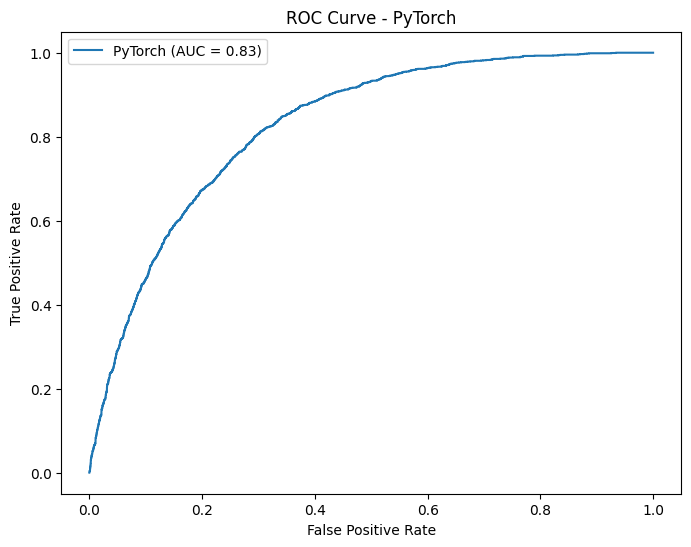

In [70]:
plt.figure(figsize=(8, 6))
fpr_torch, tpr_torch, _ = roc_curve(y_test, y_pred_torch)
plt.plot(fpr_torch, tpr_torch, label="PyTorch (AUC = %.2f)" % auc_torch)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - PyTorch")
plt.legend()
plt.show()

In [65]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_tf.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [66]:
y_pred_tf = model_tf.predict(X_test).flatten()
y_pred_class_tf = (y_pred_tf > 0.5).astype(int)

accuracy_tf = accuracy_score(y_test, y_pred_class_tf)
precision_tf = precision_score(y_test, y_pred_class_tf, zero_division=1)
recall_tf = recall_score(y_test, y_pred_class_tf)
f1_tf = f1_score(y_test, y_pred_class_tf)
auc_tf = roc_auc_score(y_test, y_pred_tf)

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


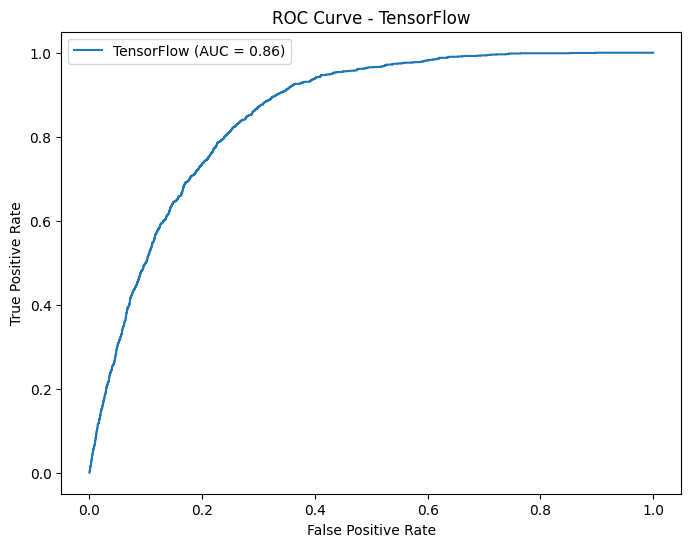

In [69]:
plt.figure(figsize=(8, 6))
fpr_tf, tpr_tf, _ = roc_curve(y_test, y_pred_tf)
plt.plot(fpr_tf, tpr_tf, label="TensorFlow (AUC = %.2f)" % auc_tf)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - TensorFlow")
plt.legend()
plt.show()

In [68]:
print("PyTorch Model:")
print(f"Accuracy: {accuracy_torch:.2f}, Precision: {precision_torch:.2f}, Recall: {recall_torch:.2f}, F1-score: {f1_torch:.2f}, AUC: {auc_torch:.2f}")

print("\nTensorFlow Model:")
print(f"Accuracy: {accuracy_tf:.2f}, Precision: {precision_tf:.2f}, Recall: {recall_tf:.2f}, F1-score: {f1_tf:.2f}, AUC: {auc_tf:.2f}")

PyTorch Model:
Accuracy: 0.81, Precision: 0.43, Recall: 0.57, F1-score: 0.49, AUC: 0.83

TensorFlow Model:
Accuracy: 0.85, Precision: 0.54, Recall: 0.30, F1-score: 0.38, AUC: 0.86


**Analisis Model Deep Learning untuk Klasifikasi Pendapatan**

1. Pendahuluan
Proyek ini bertujuan untuk melakukan klasifikasi pendapatan berdasarkan fitur-fitur demografis dan pekerjaan menggunakan dua framework deep learning, yaitu PyTorch dan TensorFlow. Model yang dikembangkan menggunakan jaringan neural sederhana dengan beberapa lapisan tersembunyi dan fungsi aktivasi ReLU. Tujuan utama adalah membandingkan performa kedua model dalam memprediksi apakah seseorang memiliki pendapatan lebih dari $50K per tahun atau tidak.

2. Ringkasan Dataset & Preprocessing
Dataset yang digunakan mengandung beberapa fitur kategori seperti workclass, education, marital-status, occupation, dll., yang dikonversi menjadi nilai numerik menggunakan Label Encoding. Data juga dinormalisasi menggunakan StandardScaler sebelum diberikan ke model.

Dataset dibagi menjadi 80% data latih dan 20% data uji dengan stratifikasi agar distribusi kelas tetap seimbang.

3. Arsitektur Model
Kedua model menggunakan arsitektur yang sama:
- Input Layer dengan jumlah neuron sesuai fitur yang tersedia.
- Hidden Layer:
  - 64 neuron dengan ReLU activation
  - 32 neuron dengan ReLU activation
- Output Layer:
  - 1 neuron dengan Sigmoid activation untuk klasifikasi biner.

Model dikompilasi dengan Binary Crossentropy Loss dan dioptimalkan menggunakan Adam Optimizer dengan learning rate 0.001.

4. Evaluasi Model
Setelah pelatihan selama 50 epoch, model dievaluasi menggunakan metrik berikut:
- Accuracy: Seberapa sering model memberikan prediksi yang benar.
- Precision: Proporsi prediksi positif yang benar.
- Recall: Kemampuan model dalam menangkap semua data positif.
- F1-score: Harmonik antara Precision dan Recall.
- AUC (Area Under Curve): Metrik yang mengukur seberapa baik model membedakan kelas positif dan negatif berdasarkan probabilitas outputnya.

**Hasil Evaluasi:**
| Metrik | PyTorch | TensorFlow |
|--------|---------|------------|
| Accuracy | 0.81 | 0.85 |
| Precision | 0.43 | 0.54 |
| Recall | 0.57 | 0.30 |
| F1-score | 0.49 | 0.38 |
| AUC | 0.83 | 0.86 |

5. Analisis Performa Model
PyTorch Model:
- Recall yang lebih tinggi (0.57) dibandingkan TensorFlow menunjukkan bahwa model lebih baik dalam mendeteksi individu dengan pendapatan tinggi (>50K).
- Namun, Precision lebih rendah (0.43), yang berarti model lebih sering memberikan prediksi positif yang salah.
- Akurasi lebih rendah dibandingkan TensorFlo*, tetapi F1-score lebih tinggi (0.49 vs. 0.38) menunjukkan keseimbangan yang lebih baik antara Precision dan Recall.

TensorFlow Model:
- Akurasi lebih tinggi (0.85) dibandingkan PyTorch, menunjukkan model lebih sering memberikan prediksi yang benar secara keseluruhan.
- Precision lebih tinggi (0.54) dibandingkan PyTorch, artinya ketika model memprediksi "pendapatan tinggi", lebih besar kemungkinan prediksi tersebut benar.
- Recall lebih rendah (0.30) dibandingkan PyTorch, yang menunjukkan model kurang sensitif terhadap kelas positif.
- AUC lebih tinggi (0.86 vs. 0.83) menunjukkan bahwa model TensorFlow lebih baik dalam membedakan antara kelas positif dan negatif secara umum.

Berikut adalah penjelasan untuk setiap persamaan matematika yang digunakan dalam proyek ini:

1. **Binary Cross-Entropy (BCELoss)**
   \[
   L = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
   \]
   **Penjelasan**:  
   - \(y_i\) adalah label asli (0 atau 1).  
   - \(\hat{y}_i\) adalah prediksi dari model (nilai antara 0 dan 1).  
   - Fungsi ini menghitung seberapa jauh perbedaan antara label asli dan prediksi dengan menggunakan logaritma.  
   - Jika model salah memprediksi, loss akan besar, sedangkan jika model mendekati label asli, loss akan kecil.

---

2. **Akurasi (Accuracy)**
   \[
   \text{Accuracy} = \frac{\text{Jumlah prediksi benar}}{\text{Total data}}
   \]
   **Penjelasan**:  
   - Akurasi mengukur seberapa sering model membuat prediksi yang benar dibandingkan dengan total jumlah sampel.
   - Nilai akurasi berkisar antara 0 hingga 1.

---

3. **Presisi (Precision)**
   \[
   \text{Precision} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP)} + \text{False Positive (FP)}}
   \]
   **Penjelasan**:  
   - Precision mengukur seberapa banyak prediksi positif yang benar dari semua prediksi positif.
   - Nilai precision tinggi berarti model jarang salah mengklasifikasikan data negatif sebagai positif.

---

4. **Recall (Sensitivitas)**
   \[
   \text{Recall} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP)} + \text{False Negative (FN)}}
   \]
   **Penjelasan**:  
   - Recall mengukur kemampuan model dalam menemukan semua sampel positif yang sebenarnya.
   - Nilai recall tinggi berarti model tidak banyak melewatkan data positif.

---

5. **F1-score**
   \[
   F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
   \]
   **Penjelasan**:  
   - F1-score adalah rata-rata harmonik antara precision dan recall.
   - Berguna saat terdapat ketidakseimbangan kelas dalam dataset, karena memberikan keseimbangan antara precision dan recall.

---

6. **Area Under Curve - Receiver Operating Characteristic (AUC-ROC)**
   \[
   AUC = \int_0^1 TPR(FPR) \, d(FPR)
   \]
   **Penjelasan**:  
   - AUC-ROC mengukur seberapa baik model dapat membedakan antara kelas positif dan negatif.
   - Semakin tinggi nilai AUC (mendekati 1), semakin baik model dalam membedakan dua kelas.

---

Setiap metrik ini digunakan untuk menilai performa model dalam mengklasifikasikan pendapatan berdasarkan fitur yang diberikan. Model dengan nilai recall tinggi akan lebih baik dalam mendeteksi semua sampel positif, sementara model dengan precision tinggi lebih berhati-hati dalam memberikan prediksi positif. Kombinasi berbagai metrik ini memberikan gambaran menyeluruh tentang kekuatan dan kelemahan model yang dikembangkan.

6. Kesimpulan
Berdasarkan hasil evaluasi, model PyTorch menunjukkan keunggulan dalam recall (0.57) dibandingkan dengan model TensorFlow (0.30), yang berarti model PyTorch lebih baik dalam mengidentifikasi kelas positif. Namun, model TensorFlow memiliki akurasi lebih tinggi (0.85 vs. 0.81) serta precision yang lebih baik (0.54 vs. 0.43), menunjukkan bahwa prediksi positifnya lebih tepat. Dari sisi keseimbangan antara precision dan recall, nilai F1-score model PyTorch (0.49) lebih tinggi dibandingkan TensorFlow (0.38), menunjukkan performa yang lebih stabil dalam mengklasifikasikan kedua kelas. Meskipun begitu, model TensorFlow memiliki nilai AUC yang lebih tinggi (0.86 vs. 0.83), yang menandakan kemampuannya dalam membedakan antara kelas positif dan negatif lebih baik secara keseluruhan. Dengan perbedaan ini, pemilihan model tergantung pada prioritas antara sensitivitas terhadap kelas positif atau keseimbangan keseluruhan performa.